In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [2]:
df_wanyi = pd.read_csv('../input/wanyi-energy/C.test_data201803.csv', index_col=[1], parse_dates=[1])

df_wanyi = df_wanyi.drop(columns="Unnamed: 0")
df_wanyi.index = df_wanyi.index+pd.Timedelta(minutes=1)
df_wanyi.head()



,KWH
time,
2006-01-02 01:00:00,0.00
2006-01-02 02:00:00,0.00
2006-01-02 03:00:00,0.00
2006-01-02 04:00:00,91.75
2006-01-02 05:00:00,68.50


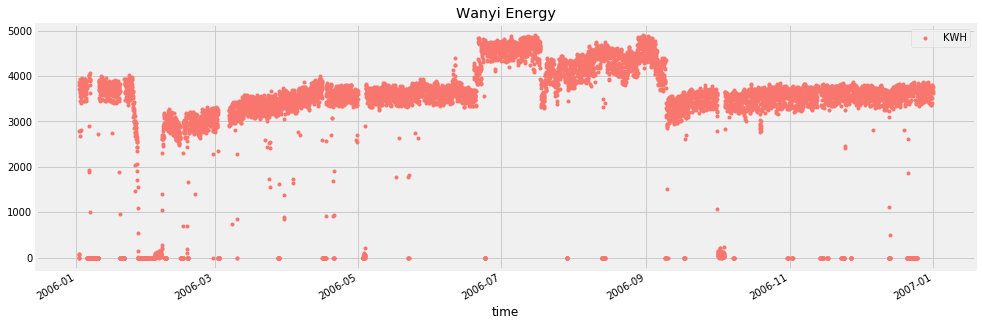

In [3]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = df_wanyi.plot(style='.', figsize=(15,5), color=color_pal[0], title='Wanyi Energy')

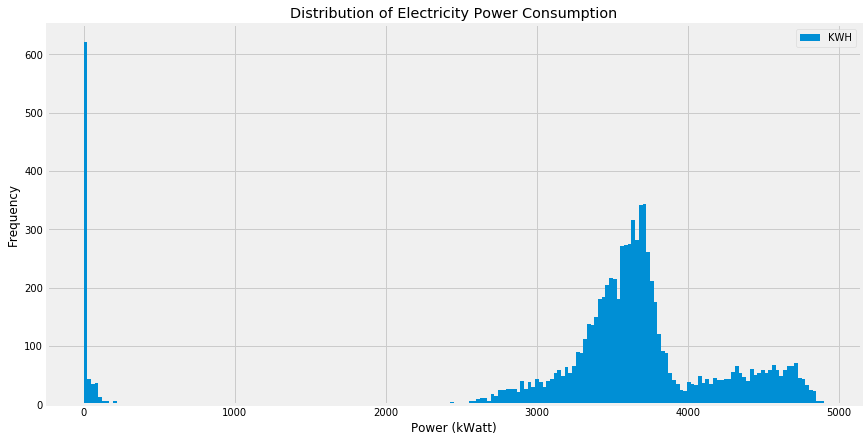

In [4]:
_ = df_wanyi.plot.hist(figsize=(13, 7), bins=200, title='Distribution of Electricity Power Consumption')
plt.xlabel('Power (kWatt)')
plt.show()

# Train/Test Split


In [5]:
df_final = df_wanyi

In [6]:
split_date = '01-Oct-2006'
wanyi_train = df_final.loc[df_final.index <= split_date].copy()
wanyi_test = df_final.loc[df_final.index > split_date].copy()

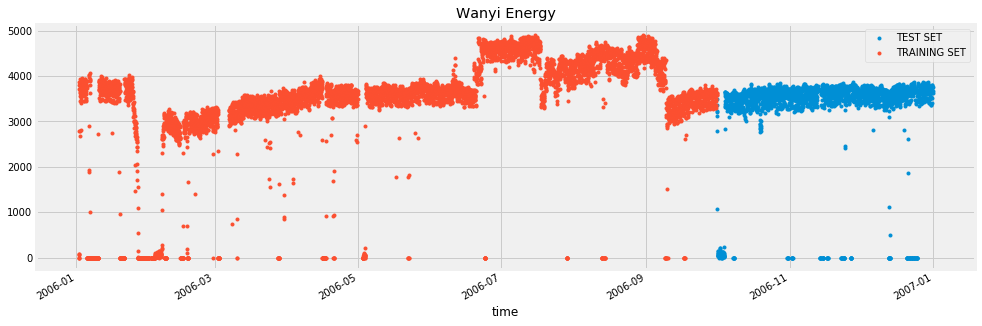

In [7]:
_ = wanyi_test \
    .rename(columns={'KWH': 'TEST SET'}) \
    .join(wanyi_train.rename(columns={'KWH': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='Wanyi Energy', style='.')

# Create Time Series Features

In [8]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

## Lag features

In [9]:


def create_lag_features(df):

    lagged_df = df.copy()

    # Next day's load values.
    lagged_df['next_hour_load'] = lagged_df['KWH'].shift(-1)    

    for hour in range(8):  
        lagged_df['load_d' + str(hour)] = lagged_df.KWH.shift(hour)

    lagged_df = lagged_df.dropna()
    

    #lagged_df = lagged_df.drop(columns=['KWH'])
    return lagged_df

In [10]:
wanyi_train = create_lag_features(wanyi_train)
wanyi_test = create_lag_features(wanyi_test)
X_train, y_train = create_features(wanyi_train, label='next_hour_load')
X_test, y_test = create_features(wanyi_test, label='next_hour_load')

#X_train, y_train = create_features(wanyi_train, label='KWH')
#X_test, y_test = create_features(wanyi_test, label='KWH')


# Create XGBoost Model

In [11]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=True) # Change verbose to True if you want to see it train

[15:13:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:3266.41	validation_1-rmse:3112.62
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:2962.85	validation_1-rmse:2831.08
[2]	validation_0-rmse:2691.15	validation_1-rmse:2580.96
[3]	validation_0-rmse:2447.04	validation_1-rmse:2359.36
[4]	validation_0-rmse:2232.34	validation_1-rmse:2163.64
[5]	validation_0-rmse:2038.03	validation_1-rmse:1991.41
[6]	validation_0-rmse:1865.71	validation_1-rmse:1840.49
[7]	validation_0-rmse:1713.3	validation_1-rmse:1688.25
[8]	validation_0-rmse:1578.66	validation_1-rmse:1557.18
[9]	validation_0-rmse:1461.12	validation_1-rmse:1463.12
[10]	validation_0-rmse:1357.17	validation_1-rmse:1383.37
[11]	validation_0-rmse:1266.89	validation_1-rmse:1302.68
[12]	validation_0-rmse:1188.65	validation

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[24]	validation_0-rmse:765.194	validation_1-rmse:983.164
[25]	validation_0-rmse:753.414	validation_1-rmse:981.691
[26]	validation_0-rmse:742.916	validation_1-rmse:980.768
[27]	validation_0-rmse:734.273	validation_1-rmse:980.472
[28]	validation_0-rmse:724.927	validation_1-rmse:980.584
[29]	validation_0-rmse:717.647	validation_1-rmse:981.047
[30]	validation_0-rmse:711.819	validation_1-rmse:981.616
[31]	validation_0-rmse:706.159	validation_1-rmse:982.012
[32]	validation_0-rmse:699.803	validation_1-rmse:981.109
[33]	validation_0-rmse:695.57	validation_1-rmse:980.858
[34]	validation_0-rmse:692.761	validation_1-rmse:980.54
[35]	validation_0-rmse:688.807	validation_1-rmse:981.378
[36]	validation_0-rmse:685.893	validation_1-rmse:982.015
[37]	validation_0-rmse:681.594	validation_1-rmse:982.853
[38]	validation_0-rmse:678.046	validation_1-rmse:983.997
[39]	validation_0-rmse:676.014	validation_1-rmse:984.397
[40]	validation_0-rmse:673.899	validation_1-rmse:986.458
[41]	validation_0-rmse:672.493	va

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

## Feature Importances


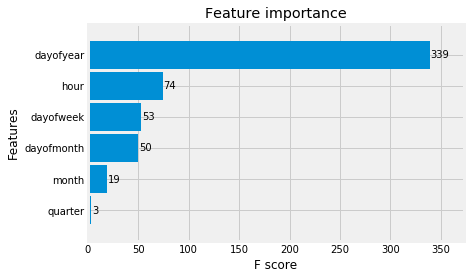

In [12]:
_ = plot_importance(reg, height=0.9)

# Forecast on Test Set

In [13]:
wanyi_test['KWH_Prediction'] = reg.predict(X_test)
# the prediction is for next hour, so shift it to next hour for compare
#wanyi_test['KWH_Prediction'] = wanyi_test['KWH_Prediction'].shift(1)
wanyi_test["KWH"]=wanyi_test["next_hour_load"]
wanyi_all = pd.concat([wanyi_test, wanyi_train], sort=False)



In [14]:
wanyi_all.head()

,KWH,next_hour_load,load_d0,load_d1,load_d2,load_d3,load_d4,load_d5,load_d6,load_d7,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,KWH_Prediction
time,,,,,,,,,,,,,,,,,,,,
2006-10-01 08:00:00,99.00,99.00,53.75,1069.25,2792.50,3117.50,3222.50,3200.00,3357.5,3502.5,2006-10-01 08:00:00,8,6,4,10,2006,274,1,39,3285.555664
2006-10-01 09:00:00,153.25,153.25,99.00,53.75,1069.25,2792.50,3117.50,3222.50,3200.0,3357.5,2006-10-01 09:00:00,9,6,4,10,2006,274,1,39,3285.555664
2006-10-01 10:00:00,148.50,148.50,153.25,99.00,53.75,1069.25,2792.50,3117.50,3222.5,3200.0,2006-10-01 10:00:00,10,6,4,10,2006,274,1,39,3285.555664
2006-10-01 11:00:00,87.75,87.75,148.50,153.25,99.00,53.75,1069.25,2792.50,3117.5,3222.5,2006-10-01 11:00:00,11,6,4,10,2006,274,1,39,3285.555664
2006-10-01 12:00:00,45.25,45.25,87.75,148.50,153.25,99.00,53.75,1069.25,2792.5,3117.5,2006-10-01 12:00:00,12,6,4,10,2006,274,1,39,3285.555664


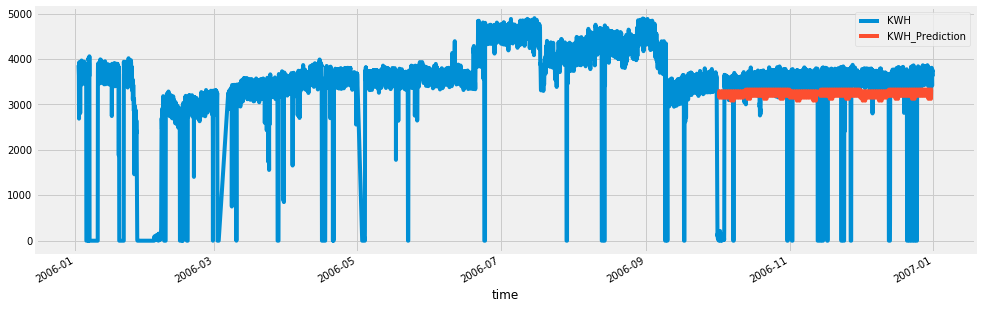

In [15]:
_ = wanyi_all[['KWH','KWH_Prediction']].plot(figsize=(15, 5))

# Look at first month of predictions

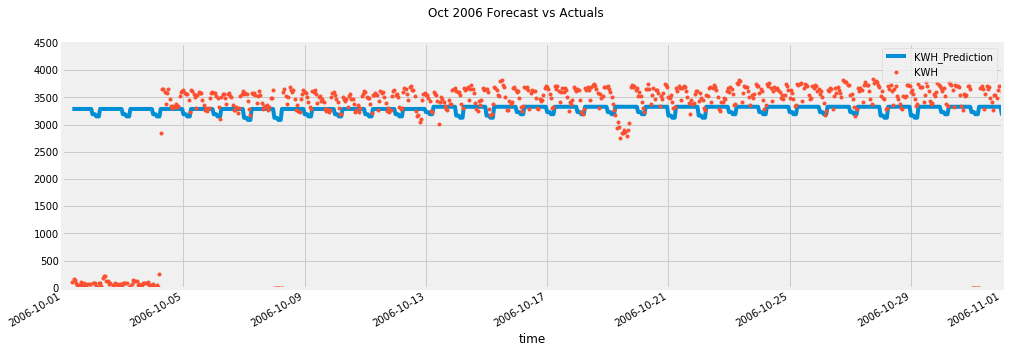

In [16]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = wanyi_all[['KWH_Prediction','KWH']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='10-01-2006', upper='11-01-2006')
ax.set_ylim(0, 4500)
plot = plt.suptitle('Oct 2006 Forecast vs Actuals')

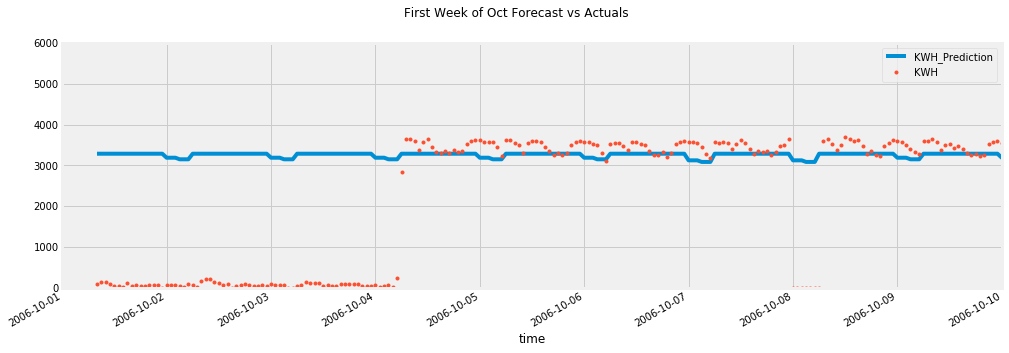

In [17]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = wanyi_all[['KWH_Prediction','KWH']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='10-01-2006', upper='10-10-2006')
ax.set_ylim(0, 6000)
plot = plt.suptitle('First Week of Oct Forecast vs Actuals')

we can see the the is error for National Day, so holiday should be considered in further.

# Error Metrics On Test Set


In [18]:
mean_squared_error(y_true=wanyi_test['KWH'],
                   y_pred=wanyi_test['KWH_Prediction'])

961326.4190238528

In [19]:
mean_absolute_error(y_true=wanyi_test['KWH'],
                   y_pred=wanyi_test['KWH_Prediction'])

553.1894513298483

I like using mean absolute percent error because it gives an easy to interperate percentage showing how off the predictions are.
MAPE isn't included in sklearn so we need to use a custom function.

In [20]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true_tmp, y_pred_tmp = np.array(y_true), np.array(y_pred)
    
    return np.mean(np.abs((y_true_tmp - y_pred_tmp) / y_pred_tmp)) *100

In [21]:
mean_absolute_percentage_error(y_true=wanyi_test['KWH'],
                   y_pred=wanyi_test['KWH_Prediction'])

16.98168530011385

# Up next?
- Add Lag variables
- Add holiday indicators.
- Add weather data source for the data source location